_author: Dana Chermesh Reshef, Director of Urban Data DRAW Brooklyn, June 2019_

# IBZ analysis
The goal of this analysis is to get an undersatnding of different lots in NYC that are under ["Industrial Business Zone" (IBZ)](https://www.nycedc.com/industry/industrial/nyc-industrial-business-zones) designation. Industrial Business Zones (IBZs) were established to protect existing manufacturing districts and encourage industrial growth citywide. 

_Background <br>
In early 2006, the City created sixteen Industrial Business Zones across the City where expanded business services are available for industrial and manufacturing businesses. This designation fosters high-performing business districts by creating competitive advantages over locating in areas outside of New York City. The IBZs are supported by tax credits for relocating within them, zone-specific planning efforts, and direct business assistance from Industrial Providers of NYC Business Solutions Industrial and Transportation. In light of the purpose of IBZs to foster industrial sector growth by creating real estate certainty, the previous administration stated that it would not support the rezoning of these areas for residential use._

See maps of the twenty-one IBZs on the [Ratified IBZs pdf](https://www.nycedc.com/sites/default/files/filemanager/All_Ratified_IBZs_Fall_2013.pdf). 

## 0. Imports

In [1]:
import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')
import json
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Data

### 1.1 IBZ NYC shapefiles
retrieved from https://www.nycedc.com/industry/industrial/nyc-industrial-business-zones

In [2]:
IBZ_NYC = gpd.GeoDataFrame.from_file('data/shp_IBZ/IBZ.shp')
print(IBZ_NYC.shape)
IBZ_NYC.head()

(21, 7)


,OBJECTID,NAME,BORONAME,BOROCODE,Shape_Leng,Shape_Area,geometry
0,1,Zerega,Bronx,2,39571.205154,1.190033e+07,(POLYGON ((1027840.762543887 240864.7069684714...
1,2,Ridgewood,Queens,4,15978.825743,1.895672e+06,(POLYGON ((1011002.226995304 192636.9953532219...
2,3,Rossville,Staten island,5,33665.853078,2.515884e+07,"POLYGON ((924909.4625013918 141810.5937253982,..."
3,4,Astoria,Queens,4,68045.262556,6.377269e+07,"POLYGON ((1022118.575497478 228105.2498758882,..."
4,5,Jamaica,Queens,4,48178.156167,1.566261e+07,(POLYGON ((1040457.783241555 193639.1655929834...


In [3]:
# checking how are IBZ's distributed across NYC boroughs 
IBZ_NYC.BORONAME.str.lower().value_counts()

queens           7
brooklyn         6
bronx            5
staten island    3
Name: BORONAME, dtype: int64

_>> There are 7 IBZ's in Queens, 6 IBZ's in Brooklyn, 5 in the Bronx and 3 in Staten Island_

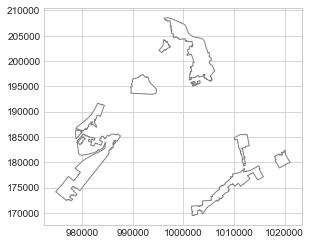

In [4]:
# plotting Brooklyn IBZ's
IBZ_NYC[IBZ_NYC.BORONAME == 'Brooklyn'].plot(color='white', edgecolor='grey')

### 1.2 IBZ NYC list of BBL by IBZ
downloaded pdf and copied data to a .csv file from https://www.nycedc.com/industry/industrial/nyc-industrial-business-zones

In [5]:
IBZ_bbl = pd.read_csv('data/IBZ_Brooklyn.csv')
IBZ_bbl = IBZ_bbl[['IBZ Area','Borough','BBL']]

print(IBZ_bbl.shape)
IBZ_bbl.head()

(4450, 3)


,IBZ Area,Borough,BBL
0,Southwest Brooklyn,Brooklyn,3002810001
1,Southwest Brooklyn,Brooklyn,3002810062
2,Southwest Brooklyn,Brooklyn,3003140001
3,Southwest Brooklyn,Brooklyn,3003140036
4,Southwest Brooklyn,Brooklyn,3003140027


In [6]:
IBZ_bbl.BBL.dtypes

dtype('int64')

In [ ]:
import csv

def reducer(accum, current):
    if current['Borough']=='BK':
        day = current['starttime'].split(' ')[0]
        if len(accum)==0 or accum[-1][0]!=day:
            return accum + [(day, int(current['birth_year']))]
    return accum     

with open('citibike.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    print(reduce(reducer, reader, []))

## 1.3 MapPLUTO data
retrieved from https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page#mappluto

In [ ]:
# from https://gis.stackexchange.com/questions/220023/only-read-specific-rows-of-a-shapefile-with-geopandas-fiona
# unhash second part when running first time

# # Dana's attempts to change the function
# def records(filename, borough, list):
#     list = sorted(list) # if the elements of the list are not sorted
#     with fiona.open(filename) as source:
#         filter = (source['Borough'] == borough)
#         for i, feature in enumerate(source[:max(list)+1]):
#             if i in list:
#                 if feature in filter:
#                     yield feature  

# def records(filename, list):
#     list = sorted(list) # if the elements of the list are not sorted
#     with fiona.open(filename) as source:
#         for i, feature in enumerate(source[:max(list)+1]):
#             if i in list:
#                 yield feature

In [83]:
# MapPLUTO_1 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(200000,220000)))
# MapPLUTO_1 = MapPLUTO_1[MapPLUTO_1.Borough == 'BK'] # BK only
# MapPLUTO_2 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(220000,240000)))
# MapPLUTO_2 = MapPLUTO_2[MapPLUTO_2.Borough == 'BK'] # BK only
# MapPLUTO_3 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(240000,260000)))
# MapPLUTO_3 = MapPLUTO_3[MapPLUTO_3.Borough == 'BK'] # BK only
# MapPLUTO_4 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(260000,280000)))
# MapPLUTO_4 = MapPLUTO_4[MapPLUTO_4.Borough == 'BK'] # BK only
# MapPLUTO_5 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(280000,300000)))
# MapPLUTO_5 = MapPLUTO_5[MapPLUTO_5.Borough == 'BK'] # BK only
# MapPLUTO_6 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(300000,320000)))
# MapPLUTO_6 = MapPLUTO_6[MapPLUTO_6.Borough == 'BK'] # BK only
# MapPLUTO_7 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(320000,340000)))
# MapPLUTO_7 = MapPLUTO_7[MapPLUTO_7.Borough == 'BK'] # BK only
# MapPLUTO_8 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(340000,360000)))
# MapPLUTO_8 = MapPLUTO_8[MapPLUTO_8.Borough == 'BK'] # BK only
# MapPLUTO_9 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(180000,200000)))
# MapPLUTO_9 = MapPLUTO_9[MapPLUTO_9.Borough == 'BK'] # BK only
# MapPLUTO_10 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(160000,180000)))
# MapPLUTO_10 = MapPLUTO_10[MapPLUTO_10.Borough == 'BK'] # BK only
# MapPLUTO_11 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(140000,160000)))
# MapPLUTO_11 = MapPLUTO_11[MapPLUTO_11.Borough == 'BK'] # BK only
# MapPLUTO_12 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(400000,420000)))
# MapPLUTO_12 = MapPLUTO_12[MapPLUTO_12.Borough == 'BK'] # BK only
# MapPLUTO_13 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(120000,140000)))
# MapPLUTO_13 = MapPLUTO_13[MapPLUTO_13.Borough == 'BK'] # BK only
# MapPLUTO_14 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(360000,380000)))
# MapPLUTO_14 = MapPLUTO_14[MapPLUTO_14.Borough == 'BK'] # BK only
# MapPLUTO_15 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(380000,400000)))
# MapPLUTO_15 = MapPLUTO_15[MapPLUTO_15.Borough == 'BK'] # BK only


MapPLUTO_test = gpd.GeoDataFrame(pd.concat([MapPLUTO_1,MapPLUTO_2,MapPLUTO_3,
                                            MapPLUTO_4,MapPLUTO_5,MapPLUTO_6,
                                            MapPLUTO_7,MapPLUTO_8,MapPLUTO_9,
                                            MapPLUTO_10,MapPLUTO_11,MapPLUTO_12,
                                            MapPLUTO_13,MapPLUTO_14,MapPLUTO_15],
                                            ignore_index=True))

# converting BBL to int
MapPLUTO_test.BBL = (MapPLUTO_test.BBL).astype(int)

# dropping columns
MapPLUTO_test = MapPLUTO_test.drop(['APPBBL', 'APPDate','AreaSource','BldgDepth','BldgFront',
                                   'BsmtCode','CB2010','EDesigNum','Easements','ExemptLand',
                                   'ExemptTot','Ext','FIRM07_FLA','FireComp','GarageArea',
                                   'HealthArea','HealthCent','HistDist','IrrLotCode','Landmark',
                                   'BoroCode','LtdHeight','OwnerName','PFIRM15_FL','PolicePrct',
                                   'ProxCode','XCoord','YCoord','Sanborn','SanitDistr','SanitSub',
                                   'TaxMap','Sanitboro','SchoolDist','Tract2010','Version',
                                   'YearBuilt','YearAlter1','YearAlter2','ZMCode','ZipCode',
                                   'PLUTOMapID','SplitZone','Overlay2','ZoneDist3',
                                   'ZoneDist4'],axis=1)

print(MapPLUTO_test.shape)
print(MapPLUTO_test.BBL.dtypes)
MapPLUTO_test.head()

(276532, 44)
int64


,Address,AssessLand,AssessTot,BBL,BldgArea,BldgClass,Block,Borough,BuiltFAR,CD,...,SPDist3,Shape_Area,Shape_Leng,StrgeArea,UnitsRes,UnitsTotal,ZoneDist1,ZoneDist2,ZoneMap,geometry
0,75 LYNCH STREET,27336.0,75427.0,3022310045,7918,B1,2231,BK,2.20,301,...,,3909.927176,283.574417,0,2,2,R6,,13b,"POLYGON ((996553.1433607191 194809.100260973, ..."
1,71 LYNCH STREET,10089.0,69088.0,3022310049,7920,C0,2231,BK,1.80,301,...,,4509.209986,295.032845,0,3,3,R6,,13b,"POLYGON ((996566.2614447176 194736.2132676393,..."
2,67 LYNCH STREET,5632.0,54432.0,3022310051,8160,C0,2231,BK,4.08,301,...,,3788.086793,281.146852,0,3,3,R6,,13b,"POLYGON ((996518.3396245539 194695.5174828917,..."
3,61 LYNCH STREET,3242.0,7404.0,3022310055,1537,A9,2231,BK,1.18,301,...,,1233.785385,232.074564,0,1,1,R6,,13b,"POLYGON ((996472.99063389 194657.0070612282, 9..."
4,59 LYNCH STREET,1242.0,7404.0,3022310056,1537,A9,2231,BK,1.18,301,...,,1323.432542,233.780200,0,1,1,R6,,13b,"POLYGON ((996463.9647333026 194649.3423783928,..."


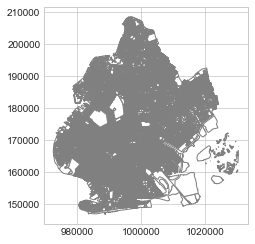

In [22]:
# plotting Brooklyn MapPLUTO
MapPLUTO_test.plot(color='white', edgecolor='grey')

In [18]:
MapPLUTO_test.to_file('MapPLUTO_test_BK.shp', driver='ESRI Shapefile')

## 1.4 PLUTO from http://chriswhong.github.io/plutoplus/#

----
## 1.4 Merging MapPLUTO with IBZ csv

In [84]:
IBZ_joint = MapPLUTO_test.merge(IBZ_bbl, on='BBL')
                                
print(IBZ_joint.shape)
IBZ_joint.head()

(4406, 46)


,Address,AssessLand,AssessTot,BBL,BldgArea,BldgClass,Block,Borough_x,BuiltFAR,CD,...,Shape_Leng,StrgeArea,UnitsRes,UnitsTotal,ZoneDist1,ZoneDist2,ZoneMap,geometry,IBZ Area,Borough_y
0,17 KENT AVENUE,11178.0,66380.0,3022780001,5000,S3,2278,BK,2.00,301,...,261.028240,0,3,4,M1-2,,12c,"POLYGON ((995967.7757650614 202858.7442666441,...",Greenpoint/Williamsburg,Brooklyn
1,9 KENT AVENUE,1202850.0,3015000.0,3022780002,111300,F1,2278,BK,1.42,301,...,1275.752403,0,0,1,M1-2,,12c,"POLYGON ((995967.7757650614 202858.7442666441,...",Greenpoint/Williamsburg,Brooklyn
2,29 WYTHE AVENUE,324000.0,1141200.0,3022790001,21000,E1,2279,BK,1.05,301,...,624.194145,0,0,3,M1-2,,13a,"POLYGON ((996454.5257758051 202728.6992511451,...",Greenpoint/Williamsburg,Brooklyn
3,180 NORTH 14 STREET,86400.0,349650.0,3022790009,8528,J6,2279,BK,1.00,301,...,382.092555,0,0,1,M1-2,,13a,"POLYGON ((996521.122427389 202674.4355801493, ...",Greenpoint/Williamsburg,Brooklyn
4,190 NORTH 14 STREET,64800.0,359550.0,3022790013,8765,J6,2279,BK,2.19,301,...,292.023862,0,1,2,M1-2,,13a,"POLYGON ((996552.8461172283 202648.586878553, ...",Greenpoint/Williamsburg,Brooklyn


In [63]:
IBZ_joint.to_file('PLUTO_BK_IBZ.shp', driver='ESRI Shapefile')

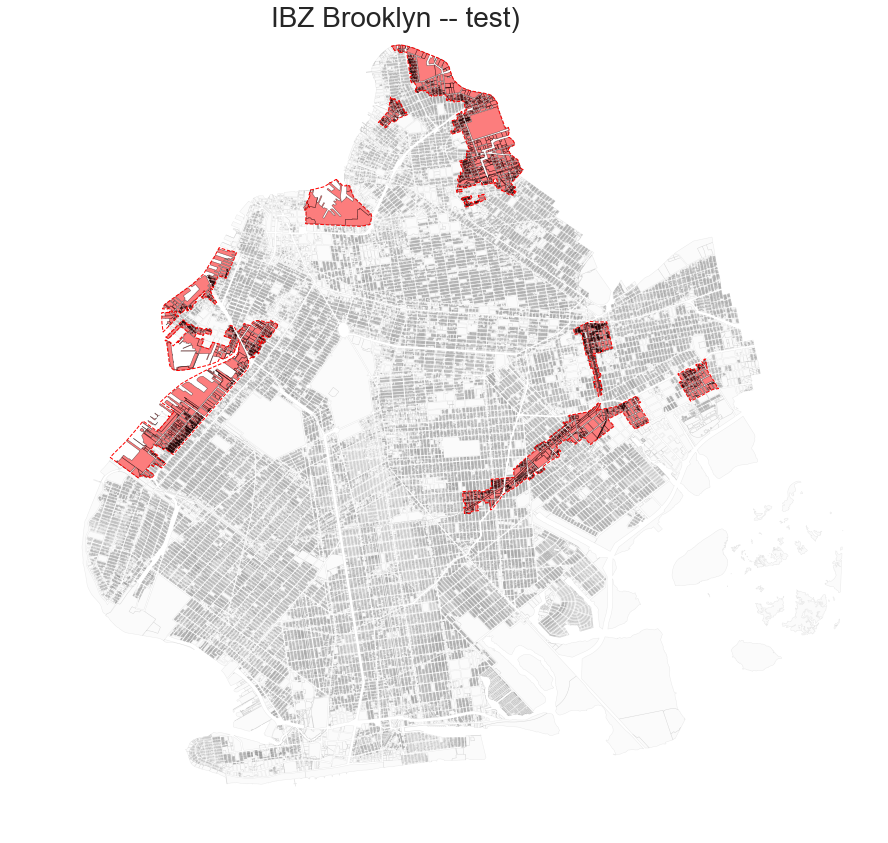

In [64]:
# plotting IBZ lots over all lots

fig = pl.figure(figsize=(15,15))
ax = fig.add_subplot(111)
MapPLUTO_test.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.5, alpha=0.08)
IBZ_joint.plot(ax=ax, color='red', edgecolor='k',linewidth=.5, alpha=0.5);
IBZ_NYC[IBZ_NYC.BORONAME == 'Brooklyn'].plot(ax=ax, color='None', edgecolor='r', linestyle='dashed',linewidth=1);

plt.title('IBZ Brooklyn -- test)', size=28, y=.97, x=0.42)
tmp = ax.axis('off')

----
## ** [PLUTO data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=18v2beta)
Detailing different categories from the data
1. **BUILDING CLASS (BldgClass)**: A code describing the major use of structures on the tax lot
2. **LAND USE CATEGORY (LandUse)**:<br>
    | VALUE   | DESCRIPTION                              |        
    | ------- |:----------------------------------------:| 
    | 01      | One & Two Family Buildings               | 
    | 02      | Multi-Family Walk-Up Buildings           |   
    | 03      | Multi-Family Elevator Buildings          |
    | 04      | Mixed Residential & Commercial Buildings | 
    | 05      | Commercial & Office Buildings            |   
    | 06      | Industrial & Manufacturing               |
    | 07      | Transportation & Utility                 | 
    | 08      | Public Facilities & Institutions         |   
    | 09      | Open Space & Outdoor Recreation          |
    | 10      | Parking Facilities                       |   
    | 11      | Vacant Land                              |  

----
# 2. Exploratory analysis of IBZ lots (_BK only_)
- How many lots contains residential uses and areas? How much?
- How many lots are adjacent to residential outside of the IBZ?

In [97]:
IBZ_joint.LandUse.value_counts()

06    1891
10     519
07     385
       361
01     307
11     297
05     261
02     158
04     149
08      67
09       9
03       2
Name: LandUse, dtype: int64

In [85]:
# creating a short df
IBZ_BK_reduced = IBZ_joint.drop(['CD','CT2010','CondoNo','OwnerType','ZoneMap',
                                'Shape_Area', 'Shape_Leng','Council'],axis=1)
print(IBZ_BK_reduced.shape)
IBZ_BK_reduced.columns

(4406, 38)


Index(['Address', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass',
       'Block', 'Borough_x', 'BuiltFAR', 'ComArea', 'CommFAR', 'FacilFAR',
       'FactryArea', 'LandUse', 'Lot', 'LotArea', 'LotDepth', 'LotFront',
       'LotType', 'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea',
       'Overlay1', 'ResArea', 'ResidFAR', 'RetailArea', 'SPDist1', 'SPDist2',
       'SPDist3', 'StrgeArea', 'UnitsRes', 'UnitsTotal', 'ZoneDist1',
       'ZoneDist2', 'geometry', 'IBZ Area', 'Borough_y'],
      dtype='object')

In [99]:
# renaming LandUse according to the PLUTO dictionary 
IBZ_joint.LandUse = IBZ_joint.LandUse.rename({'01': 'One & Two Family Buildings',
                          '02': 'Multi-Family Walk-Up Buildings',
                          '03': 'Multi-Family Elevator Buildings',
                          '04': 'Mixed Residential & Commercial Buildings',
                          '05': 'Commercial & Office Buildings',
                          '06': 'Industrial & Manufacturing',
                          '07': 'Transportation & Utility',
                          '08': 'Public Facilities & Institutions',
                          '09': 'Open Space & Outdoor Recreation',
                          '10': 'Parking Facilities',
                          '11': 'Vacant Land'})

IBZ_joint.LandUse.unique()

array(['04', '06', '05', '02', '', '10', '07', '08', '01', '11', '03',
       '09'], dtype=object)

In [125]:
IBZ_BK_reduced[IBZ_BK_reduced.LandUse == '01'][['BBL','LandUse','BuiltFAR','ResidFAR','UnitsRes','UnitsTotal']][::70]
# IBZ_BK_reduced[IBZ_BK_reduced.LandUse == '02'][['BBL','LandUse','BuiltFAR','ResidFAR','UnitsTotal','UnitsRes']]
# IBZ_BK_reduced[IBZ_BK_reduced.LandUse == '03'][['BBL','LandUse','BuiltFAR','ResidFAR','UnitsTotal','UnitsRes']]
# IBZ_BK_reduced[IBZ_BK_reduced.LandUse == '04'][['LandUse','BuiltFAR','ResidFAR','UnitsTotal','UnitsRes']]

,BBL,LandUse,BuiltFAR,ResidFAR,UnitsRes,UnitsTotal
78,3024970003,01,0.76,0.00,2,2
1356,3031760052,01,0.40,0.00,2,2
2612,3005740031,01,0.40,0.00,2,2
3266,3007810064,01,1.02,1.65,2,2
3919,3077450048,01,0.61,0.00,1,1


In [132]:
IBZ_blocks = IBZ_BK_reduced.set_index('Block')
IBZ_blocks = IBZ_blocks[['BuiltFAR','LandUse','BuiltFAR','ResidFAR','UnitsRes','UnitsTotal','ZoneDist1']]

IBZ_blocks.head()

,BuiltFAR,LandUse,BuiltFAR,ResidFAR,UnitsRes,UnitsTotal,ZoneDist1
Block,,,,,,,
2278,2.00,04,2.00,0.0,3,4,M1-2
2278,1.42,06,1.42,0.0,0,1,M1-2
2279,1.05,06,1.05,0.0,0,3,M1-2
2279,1.00,05,1.00,0.0,0,1,M1-2
2279,2.19,05,2.19,0.0,1,2,M1-2


In [152]:
IBZ_blocks_grouped = IBZ_BK_reduced.groupby('Block').sum()
IBZ_blocks_grouped = IBZ_blocks_grouped[['BuiltFAR','ResidFAR','UnitsRes','UnitsTotal']]

print(IBZ_blocks_grouped.shape)
IBZ_blocks_grouped.head()

(516, 4)


,BuiltFAR,ResidFAR,UnitsRes,UnitsTotal
Block,,,,
281,0.64,0.0,0,2
314,0.00,0.0,0,0
316,0.00,0.0,0,0
318,0.00,0.0,0,0
334,2.87,0.0,0,6


In [159]:
resi = IBZ_blocks_grouped[IBZ_blocks_grouped.ResidFAR != 0.0]
resi['resPercent'] = resi['ResidFAR']/resi['BuiltFAR']


print(resi.shape)
print('number of blocks that have more than 30% of built Residential FAR are:',
     resi[resi['resPercent'] > 0.30].shape[0])

resi[resi['resPercent'] > 0.30]

(20, 5)
number of blocks that have more than 30% of built Residential FAR are: 18


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,BuiltFAR,ResidFAR,UnitsRes,UnitsTotal,resPercent
Block,,,,,
580,4.00,1.25,0,3,0.312500
736,56.30,49.50,70,94,0.879218
745,59.40,67.65,105,123,1.138889
754,31.76,36.30,19,45,1.142947
763,30.37,37.95,9,33,1.249588
772,29.48,39.60,14,37,1.343284
781,49.95,69.30,67,84,1.387387
789,54.72,69.30,78,103,1.266447
797,65.18,72.60,66,101,1.113839


In [86]:
# lots that has an Overlay of C1-3
# There are 5 lots with C1-3 Overlay in BK IBZ's 
# There are no lots in BK IBZ's with Overlay2, thus this column was dropped from the dataset

IBZ_BK_reduced[IBZ_BK_reduced['Overlay1'] != ''].Overlay1

2544    C1-3
2545    C1-3
2558    C1-3
2576    C1-3
2619    C1-3
Name: Overlay1, dtype: object

In [88]:
# CondoNo is ??
IBZ_joint[IBZ_joint['CondoNo'] != 0].CondoNo

400     1984
922      646
2569     960
Name: CondoNo, dtype: int64

In [91]:
IBZ_BK_reduced.BldgClass.unique()

array(['S3', 'F1', 'E1', 'J6', 'K1', 'O2', 'D7', 'O6', 'HB', 'O5', 'F5',
       'K4', 'C2', 'K2', 'H2', 'Z9', 'G0', 'C0', 'S2', 'G7', 'H1', 'O1',
       'F9', 'O8', 'H3', 'G2', 'N2', 'F8', 'U5', 'B9', 'C4', 'G1', 'F4',
       'A9', 'S4', 'Y6', 'G9', 'J9', 'E7', 'E9', 'C1', 'S9', 'V1', 'U9',
       'Y9', 'L9', 'G6', 'B2', 'GU', 'E2', 'G5', 'Y1', 'G4', 'K9', 'H8',
       'RB', 'M1', 'M3', 'P2', 'O9', 'G3', 'S1', 'C3', 'U2', 'GW', 'U1',
       'RW', 'F2', 'U7', 'V9', 'A1', 'U8', 'H9', 'D2', 'W9', 'U6', 'T9',
       'Q9', 'W8', 'B1', 'M9', 'I9', 'Q1', 'C7', 'B3', 'S5', 'P5', 'K5',
       'P6', 'V2', 'A2', 'H4', 'K6', 'O7', 'V0', 'W4', '', 'W3', 'W1',
       'P9', 'T2', 'G8', 'Y4', 'A3', 'V3', 'U0', 'T1', 'I5', 'RM', 'Z3',
       'A5', 'M2', 'K8', 'Y3', 'L2', 'C6', 'N9', 'HR', 'Z7', 'Y7', 'K7'],
      dtype=object)

In [81]:
IBZ_joint[['LotArea','AssessLand','AssessTot', 'BuiltFAR', 'ResidFAR', 'FacilFAR','NumFloors']][::250]

,LotArea,AssessLand,AssessTot,BuiltFAR,ResidFAR,FacilFAR,NumFloors
0,2500,11178.0,66380.0,2.00,0.00,4.8,3.0
250,3000,33750.0,192600.0,1.40,0.00,2.4,2.0
500,1746,7178.0,25878.0,2.15,0.00,0.0,3.0
750,5000,90000.0,212400.0,1.00,0.00,2.4,1.0
1000,2563,47250.0,47250.0,0.00,0.00,4.8,0.0
1250,13000,173700.0,210600.0,0.00,0.00,2.4,0.0
1500,2000,5270.0,8686.0,1.40,0.00,6.5,3.0
1750,5000,22500.0,159750.0,1.00,0.00,6.5,1.0
2000,21000,193950.0,614700.0,0.90,0.00,2.4,1.0
2250,3992,71550.0,166050.0,1.00,0.00,2.4,1.0


In [67]:
IBZ_joint[['BBL','Borough_x','BldgClass','BuiltFAR','CommFAR','LandUse','ResArea',
           'ResidFAR','ZoneDist1','UnitsRes','UnitsTotal','NumBldgs',
           'OwnerType']][::250]

,BBL,Borough_x,BldgClass,BuiltFAR,CommFAR,LandUse,ResArea,ResidFAR,ZoneDist1,UnitsRes,UnitsTotal,NumBldgs,OwnerType
0,3022780001,BK,S3,2.00,2.0,04,3010,0.00,M1-2,3,4,3,
250,3025820105,BK,F9,1.40,1.0,06,0,0.00,M1-1,0,1,1,
500,3026940001,BK,S2,2.15,2.0,04,2250,0.00,M3-1,2,3,1,
750,3028690005,BK,F9,1.00,1.0,06,0,0.00,M1-1,0,1,1,
1000,3029910001,BK,Z9,0.00,2.0,,0,0.00,M1-2,0,0,1,
1250,3030820089,BK,Z9,0.00,1.0,,0,0.00,M1-1,0,0,2,
1500,3036810035,BK,C0,1.40,2.0,02,2100,0.00,M1-4,3,3,1,
1750,3037150035,BK,E9,1.00,2.0,06,0,0.00,M1-4,0,1,1,
2000,3038830027,BK,E1,0.90,1.0,06,0,0.00,M1-1,0,1,1,
2250,3045210015,BK,E1,1.00,1.0,06,0,0.00,M1-1,0,1,1,


In [30]:
IBZ_joint.LandUse.value_counts()

06    1891
10     519
07     385
       361
01     307
11     297
05     261
02     158
04     149
08      67
09       9
03       2
Name: LandUse, dtype: int64

KeyboardInterrupt: 

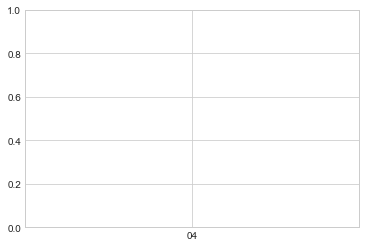

In [31]:
IBZ_joint.LandUse.hist()

0     757
2      57
4      10
6       9
1       8
3       5
5       4
8       3
7       3
32      2
22      1
13      1
Name: UnitsRes, dtype: int64


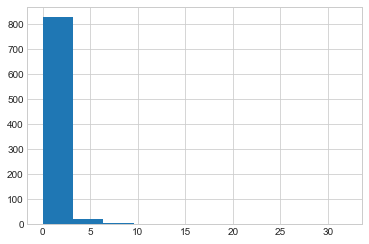

In [182]:
print(IBZ_joint.UnitsRes.value_counts())
IBZ_joint.UnitsRes.hist()

----
### _nyc zoning tax lot data - Not in use now_

In [11]:
# nyc zoning tax lot data -- not a .shp
pd.read_csv('nyczoningtaxlotdb_20190430/NY_ZoningTaxLotDB20190430.csv').head()

/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Borough Code,Tax Block,Tax Lot,BBL,Zoning District 1,Zoning District 2,Zoning District 3,Zoning District 4,Commercial Overlay 1,Commercial Overlay 2,Special District 1,Special District 2,Special District 3,Limited Height District,Zoning Map Number,Zoning Map Code
0,3.0,6013,1,3060130001,PARK,R2,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,22A,Y
1,1.0,215,15,1002150015,C6-2A,NaN,NaN,NaN,NaN,NaN,TMU,NaN,NaN,NaN,12A,NaN
2,1.0,219,13,1002190013,C6-2A,NaN,NaN,NaN,NaN,NaN,TMU,NaN,NaN,NaN,12A,NaN
3,1.0,224,30,1002240030,C6-2A,NaN,NaN,NaN,NaN,NaN,TMU,NaN,NaN,NaN,12A,NaN
4,1.0,236,16,1002360016,C6-2G,NaN,NaN,NaN,NaN,NaN,LI,NaN,NaN,NaN,12C,NaN
